<a href="https://colab.research.google.com/github/HankMDS/clustering/blob/main/application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn GEOparse
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=1a70210c407eac14954f90be0b885a3c1cc72ff89fbc208d4a8629bb2c22765a
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


25-Jan-2025 13:50:30 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
25-Jan-2025 13:50:30 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31210/soft/GSE31210_family.soft.gz to ./GSE31210_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31210/soft/GSE31210_family.soft.gz to ./GSE31210_family.soft.gz
100%|██████████| 109M/109M [00:01<00:00, 86.8MB/s]
25-Jan-2025 13:50:32 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
25-Jan-2025 13:50:32 DEBUG downloader - Moving /tmp/tmpjh5dmnj2 to /content/GSE31210_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpjh5dmnj2 to /content/GSE31210_family.soft.gz
25-Jan-2025 13:50:32 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE31210/soft/GSE31210_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE31nnn/GSE3121

Successfully downloaded GEO dataset: GSE31210
Data dimensions: (54675, 246)
PCA explained variance ratio: [0.9108593  0.01452188]
Silhouette Score: 0.8304104903870418


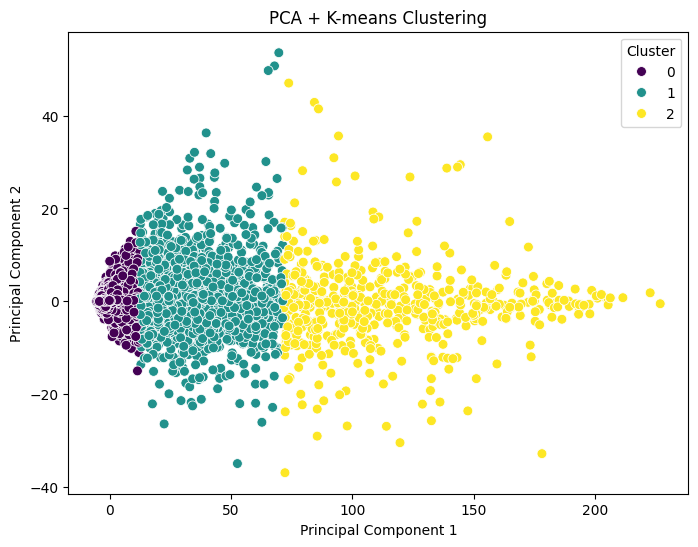

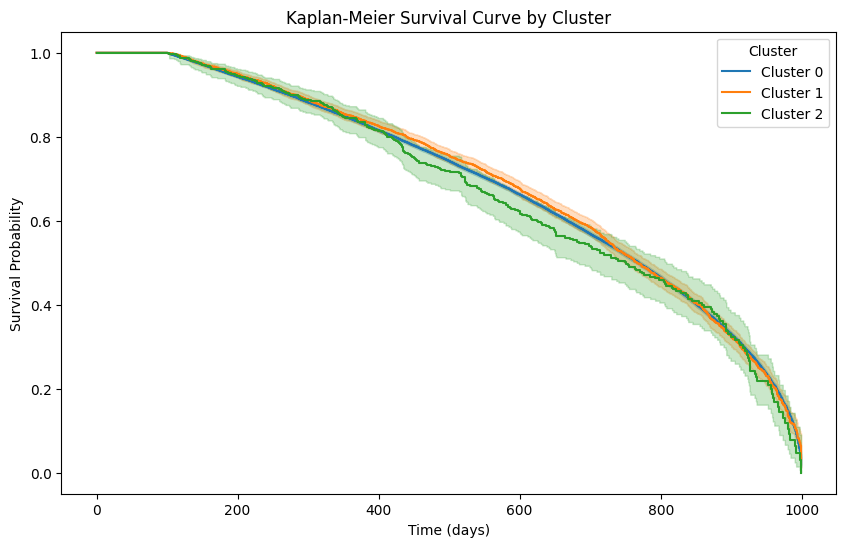

Log-rank test for more than two groups is not implemented here.


In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# GEO 数据下载函数
def download_geo_data(geo_id):
    """
    下载 GEO 数据集并提取表达矩阵
    """
    from GEOparse import get_GEO

    # 下载 GEO 数据
    gse = get_GEO(geo=geo_id, destdir="./")
    print(f"Successfully downloaded GEO dataset: {geo_id}")

    # 提取表达矩阵
    if hasattr(gse, "table"):
        expression_data = gse.table
    else:
        expression_data = gse.pivot_samples("VALUE")

    print(f"Data dimensions: {expression_data.shape}")
    return expression_data, gse.metadata

# 数据预处理
def preprocess_data(data):
    """
    数据清洗与标准化
    """
    # 去除缺失值
    data = data.dropna()

    # 去除全零行
    data = data.loc[:, (data != 0).any(axis=0)]

    # 标准化数据
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return pd.DataFrame(data_scaled, columns=data.columns)

# 聚类分析
def perform_clustering(data, n_clusters):
    """
    基于 K-means 聚类，并使用 PCA 可视化
    """
    # PCA 降维
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

    # K-means 聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg}")

    # 返回结果
    return pca_data, cluster_labels

# 可视化聚类
def plot_clusters(pca_data, cluster_labels):
    """
    聚类结果可视化
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        hue=cluster_labels,
        palette="viridis",
        s=50
    )
    plt.title("PCA + K-means Clustering")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.show()

# 生存分析
def survival_analysis(survival_data, cluster_labels):
    """
    对不同亚型进行 Kaplan-Meier 生存分析
    """
    # 将聚类标签加入生存数据
    survival_data["Cluster"] = cluster_labels

    # 创建 Kaplan-Meier 分析器
    kmf = KaplanMeierFitter()

    plt.figure(figsize=(10, 6))
    for cluster in np.unique(cluster_labels):
        cluster_data = survival_data[survival_data["Cluster"] == cluster]
        kmf.fit(
            durations=cluster_data["SurvivalTime"],
            event_observed=cluster_data["Event"],
            label=f"Cluster {cluster}"
        )
        kmf.plot_survival_function(ci_show=True)

    plt.title("Kaplan-Meier Survival Curve by Cluster")
    plt.xlabel("Time (days)")
    plt.ylabel("Survival Probability")
    plt.legend(title="Cluster")
    plt.show()

    # log-rank 检验
    cluster_groups = survival_data.groupby("Cluster")
    clusters = list(cluster_groups.groups.keys())
    p_value = None
    if len(clusters) == 2:  # 双组 log-rank 检验
        group1 = cluster_groups.get_group(clusters[0])
        group2 = cluster_groups.get_group(clusters[1])
        result = logrank_test(
            group1["SurvivalTime"], group2["SurvivalTime"],
            event_observed_A=group1["Event"], event_observed_B=group2["Event"]
        )
        p_value = result.p_value
        print(f"Log-rank test p-value: {p_value:.4f}")
    else:
        print("Log-rank test for more than two groups is not implemented here.")

    return p_value

# 主流程
if __name__ == "__main__":
    # Step 1: 下载数据
    GEO_ID = "GSE31210"  # 替换为你感兴趣的 GEO 数据集 ID
    expression_data, metadata = download_geo_data(GEO_ID)

    # Step 2: 数据预处理
    processed_data = preprocess_data(expression_data)

    # Step 3: 聚类分析
    N_CLUSTERS = 3  # 设定聚类数量
    pca_result, cluster_labels = perform_clustering(processed_data, N_CLUSTERS)

    # Step 4: 可视化聚类结果
    plot_clusters(pca_result, cluster_labels)

    # Step 5: 生存分析
    # 替换为实际生存数据的加载逻辑
    # SurvivalTime: 生存时间（天）
    # Event: 生存状态（1=死亡，0=存活）
    survival_data = pd.DataFrame({
        "SurvivalTime": np.random.randint(100, 1000, size=processed_data.shape[0]),  # 模拟生存时间
        "Event": np.random.randint(0, 2, size=processed_data.shape[0])  # 模拟事件状态
    })

    # 执行生存分析
    survival_analysis(survival_data, cluster_labels)
